Simulated data contains  200  - samples and  5  - features
Confound Isolation cross-validation method is processing.....
Out_of_sample deconfounding method is processing.....
Without deconfounding .....
Deconfound jointly .....


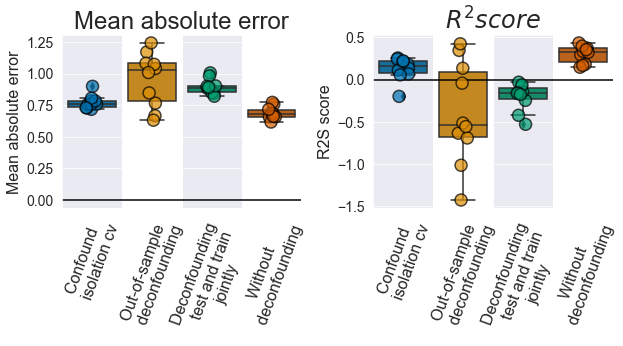

In [8]:
"""
Example of prediction of 'y' from 'X' with presence of confound 'z' (direct
link between 'y' and 'z') with 4 different deconfound strategies:
1. Confound Isolation cross-validation method
2. 'Out_of_sample' deconfounding
3. 'Jointly' deconfounding
4. Without deconfounding

"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from confound_prediction.data_simulation import simulate_confounded_data

from confound_prediction.deconfounding import (confound_isolating_cv,
                                               confound_regressout)
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             explained_variance_score, r2_score)


def model_fit_datasplit(x_train_cv, x_test_cv, y_train_cv, y_test_cv, model):
    mse = []
    mae = []
    evs = []
    r2s = []
    for x_train, x_test, y_train, y_test in zip(x_train_cv, x_test_cv,
                                                y_train_cv, y_test_cv):
        # print('Start prediction with ', model)
        model.fit(x_train, y_train)
        test_predict = model.predict(x_test)

        # Mean squared error
        mse.append(mean_squared_error(y_test, test_predict))
        # Mean absolute error
        mae.append(mean_absolute_error(y_test, test_predict))
        # Explained variance score
        evs.append(explained_variance_score(y_test, test_predict))
        # R^2 score
        r2s.append(r2_score(y_test, test_predict))
    return mse, mae, evs, r2s


# Simulate data
X, y, z, = simulate_confounded_data(link_type='no_link', n_samples=200,
                                    n_features=5)
# np.vstack([z,3*z]).T
print('Simulated data contains ', X.shape[0], ' - samples and ', X.shape[1],
      ' - features')

# Get the train and test data with Confound Isolation cross-validation method
print('Confound Isolation cross-validation method is processing.....')
x_test_cicv, x_train_cicv, y_test_cicv, y_train_cicv, _, _ = \
    confound_isolating_cv(X, y, z, random_seed=None, min_sample_size=None,
                          cv_folds=10, n_remove=None)

# Get the train and test data with 'out_of_sample' deconfounding
print('Out_of_sample deconfounding method is processing.....')
x_test_oos, x_train_oos, y_test_oos, y_train_oos, _, _ = \
    confound_regressout(X, y, z, type_deconfound='out_of_sample',
                        min_sample_size=None, cv_folds=10, n_remove=None)

# Get the train and test data without deconfounding
print('Without deconfounding .....')
x_test_fa, x_train_fa, y_test_fa, y_train_fa, _, _ = \
    confound_regressout(X, y, z, type_deconfound='False',
                        min_sample_size=None, cv_folds=10, n_remove=None)

# Get the train and test data with 'jointly' deconfounding
print('Deconfound jointly .....')
x_test_jo, x_train_jo, y_test_jo, y_train_jo, _, _ = \
    confound_regressout(X, y, z, type_deconfound='jointly',
                        min_sample_size=None, cv_folds=10, n_remove=None)

# Prediction
model = RidgeCV()

mse_cicv, mae_cicv, evs_cicv, r2s_cicv = \
    model_fit_datasplit(x_test_cicv, x_train_cicv, y_test_cicv, y_train_cicv,
                        model)

mse_oos, mae_oos, evs_oos, r2s_oos = \
    model_fit_datasplit(x_test_oos, x_train_oos, y_test_oos, y_train_oos,
                        model)

mse_jo, mae_jo, evs_jo, r2s_jo = \
    model_fit_datasplit(x_test_jo, x_train_jo, y_test_jo, y_train_jo, model)

mse_fa, mae_fa, evs_fa, r2s_fa = model_fit_datasplit(x_test_fa, x_train_fa,
                                                     y_test_fa, y_train_fa,
                                                     model)
mae_plot = [np.array(mae_cicv), np.array(mae_oos), np.array(mae_jo),
            np.array(mae_fa)]

r2s_plot = [np.array(r2s_cicv), np.array(r2s_oos), np.array(r2s_jo),
            np.array(r2s_fa)]

df_mae = pd.DataFrame({'cicv': mae_cicv,
                       'oos': mae_oos,
                       'ma': mae_jo,
                       'fa': mae_fa})
df_mae_plot = pd.melt(df_mae.reset_index(),
                      value_vars=df_mae.columns.values.tolist(),
                      var_name='confound', value_name='value')

df_r2s = pd.DataFrame({'cicv': r2s_cicv,
                       'oos': r2s_oos,
                       'ma': r2s_jo,
                       'fa': r2s_fa})
df_r2s_plot = pd.melt(df_r2s.reset_index(),
                      value_vars=df_r2s.columns.values.tolist(),
                      var_name='confound', value_name='value')

# Plotting
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor': 'white'})
for i in range(1, 16, 2):
    ax1.axvspan(i-0.5, i+0.5, facecolor='white', zorder=-1)
    ax2.axvspan(i - 0.5, i + 0.5, facecolor='white', zorder=-1)

# MAE
sns.boxplot(x="confound", y="value", data=df_mae_plot, palette="colorblind",
            ax=ax1)

sns.stripplot(x="confound", y="value", data=df_mae_plot, jitter=True,
              dodge=True, marker='o', alpha=0.7, size=12, edgecolor='black',
              linewidth=1.5, palette="colorblind", ax=ax1)

# R2s
sns.boxplot(x="confound", y="value", data=df_r2s_plot, palette="colorblind",
            ax=ax2)

sns.stripplot(x="confound", y="value", data=df_r2s_plot, jitter=True,
              dodge=True, marker='o', alpha=0.7, size=12, edgecolor='black',
              linewidth=1.5, palette="colorblind", ax=ax2)

# Tickes
ax1.axhline(y=0.0, color='black', linestyle='-')
ax2.axhline(y=0.0, color='black', linestyle='-')

labels = ['Confound \n isolation cv',
          'Out-of-sample \n deconfounding',
          'Deconfounding \n test and train\njointly',
          'Without \n deconfounding']

ax1.set_xticklabels(labels, fontsize=16, rotation=70)
ax2.set_xticklabels(labels, fontsize=16, rotation=70)
ax1.xaxis.set_tick_params(length=5)
ax2.xaxis.set_tick_params(length=5)
ax1.yaxis.set_tick_params(labelsize=14, length=5)
ax2.yaxis.set_tick_params(labelsize=14, length=5)

# Axes
ax1.set_title('Mean absolute error', fontsize=24)
ax2.set_title(r'$R^2  score$', fontsize=24)

ax1.set_ylabel("Mean absolute error",fontsize=16)
ax2.set_ylabel("R2S score",fontsize=16)
ax1.set_xlabel("",fontsize=30)
ax2.set_xlabel("",fontsize=30)

plt.gcf().subplots_adjust(bottom=0.4, left=0.1, right=0.95, wspace=0.3)
plt.show()

In [2]:
from confound_prediction.deconfounding import deconfound_model_jointly, confound_isolating_cv



In [3]:
def simulate_confounded_data_multiple_var(link_type='direct_link',
                             n_samples=100, n_features=100, n_factors=1):
    """
    :param link_type: str,
        Type of the links between target and confound. Options: "no_link",
        "direct_link", "weak_link"
    :param n_samples: int,
        number of samples
    :param n_features: int,
        number of features
    :return:
    """
    np.random.seed(42)

    mu, sigma = 0, 1.0  # mean and standard deviation
    x_rand = np.random.normal(mu, sigma, [n_samples, n_features])
    y_rand = np.random.normal(mu, sigma, [n_samples,1])
    z_rand = np.random.normal(mu, sigma, [n_samples, n_factors])

    if link_type == 'no_link':
        y = np.copy(y_rand)
        z = 1 * y_rand + z_rand
        X = x_rand + z
    elif link_type == 'direct_link':
        y = np.copy(y_rand)
        z = y_rand + z_rand
        X = x_rand + y_rand + np.sum(z, axis=1).reshape((-1,1))
    elif link_type == 'weak_link':
        y = np.copy(y_rand)
        z = 0.5 * y_rand + z_rand
        X = x_rand + y_rand + np.sum(z, axis=1).reshape((-1,1))
    return X, y, z

X1, y1, z1, = simulate_confounded_data_multiple_var(link_type='direct_link', n_samples=100,
                                    n_features=5, n_factors=3)

In [4]:
# deconfound_model_jointly(X,z)

# x_test, x_train, y_test, y_train, ids_test, ids_train = confound_isolating_cv(X, y, np.vstack([z,3*z]))
import numpy as np
from scipy.stats.kde import gaussian_kde

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.datasets.base import Bunch

from confound_prediction.mutual_information import mutual_kde

from statsmodels.formula.api import ols

def confound_isolating_index_2remove_multiple_var(y, z, n_remove=None, prng=None):
    """
    The goal is to find a test set with independence between y and z
    :param y: numpy.array, shape (n_samples), target
    :param z: numpy.array, shape (n_samples), confound
    :param n_remove: int,
        number to be removed in each iteration, the default is 4
    :param prng: np.random.RandomState, default is None
        control the pseudo random number generator
    :return: numpy.array, shape (m_samples),
        index to be removed, m < n
    """

    n_remove = _ensure_int_positive(n_remove, default=4)

    y_train, y_test, z_train, z_test, index_train, index_test = \
        train_test_split(y, z, np.arange(y.shape[0]), test_size=0.25,
                         random_state=42)

#     yz_train = np.array((y_train, z_train))
    yz_train = np.hstack([y_train.reshape((-1,1)),z_train]).T
#     yz_test = np.array((y_test, z_test))
    yz_test = np.hstack([y_test.reshape((-1,1)),z_test]).T
    # Scaling for kde

    bandwidth = 'scott'
    scaler = preprocessing.StandardScaler()
    scaler.fit(yz_train.T)

    train_scaled = scaler.transform(yz_train.T).T
    test_scaled = scaler.transform(yz_test.T).T
    kde_yz = gaussian_kde(train_scaled, bw_method=bandwidth)
    # Bandwidth: train and test on kde_yz, and use it for kde_y and kde_z
    bandwidth_xy = kde_yz.factor
    kde_y = gaussian_kde(train_scaled[0], bw_method=bandwidth_xy)
    kde_z = gaussian_kde(train_scaled[1:], bw_method=bandwidth)
    # Ratio, to find max
    ratio_dens = (kde_yz(test_scaled)) / (kde_y(test_scaled[0]) * kde_z(
        test_scaled[1:]))  # + 1e-4

    # Subjects to remove
    index_sort = np.argsort(ratio_dens)
    ratio_sort = ratio_dens[np.argsort(ratio_dens)]
    empirical_cdf = (np.cumsum(ratio_sort)) ** 5

    # TODO add parameters of number of discarded subjects, at the moment is
    #  a constant = 4

    if prng is None:
        random_quantiles = np.random.random(size=n_remove) * empirical_cdf.max()
    else:
        random_quantiles = prng.rand(n_remove) * empirical_cdf.max()
    idx_to_reject = np.searchsorted(empirical_cdf, random_quantiles,
                                    side='left')
    # Index from test subset to be removed
    index_to_remove = index_test[index_sort[idx_to_reject]]

    # TODO remove repetitions in the index_to_remove, but not sure its
    #  possible or important

    return index_to_remove


def confound_isolating_sampling_multiple_var(y, z, random_seed=None, min_sample_size=None,
                                n_remove=None):
    """
    Sampling method based on the 'Confound isolating cross-validation'
    technique.
    # TODO Reference to the paper
    :param y: numpy.array, shape (n_samples), target
    :param z: numpy.array, shape (n_samples), confound
    :param random_seed: int
        Random seed used to initialize the pseudo-random number generator.
        Can be any integer between 0 and 2**32 - 1 inclusive. Default is None
    :param min_sample_size: int
        Minimum sample size (in samples) to be reached, default is 10% of the
        data
    :param n_remove: int,
        number of the samples to be removed on each iteration of sampling,
        default is 4
    :return:
        sampled_index,
        mutual_information
        correlation
    """

    sampled_index = list(range(0, y.shape[0]))
    mutual_information = []
    correlation = []
    multiple_correlation = []
    index_to_remove = []

    n_remove = _ensure_int_positive(n_remove, default=4)

    min_sample_size = _ensure_int_positive(min_sample_size, default=10)
    min_size = np.int(y.shape[0] * min_sample_size / 100)

    while y.shape[0] > min_size:

        # remove subject from the previous iteration
        y = np.delete(y, index_to_remove, axis=0)
        z = np.delete(z, index_to_remove, axis=0)
        sampled_index = np.delete(sampled_index, index_to_remove, axis=0)
        # control the pseudo random number generator
        if random_seed is None:
            prng = None
        else:
            prng = np.random.RandomState(seed=random_seed)

        # return indexes
        index_to_remove = confound_isolating_index_2remove_multiple_var(y, z,
                                                           n_remove=n_remove,
                                                           prng=prng)
        mutual_informations = []
        correlations = []
        for confound_idx in range(z.shape[1]):
            # The case when target and confound are equal
            if np.all(y==z[:,confound_idx]) == True:
                mutual_informations.append('NaN')
            else:
#                 import pdb
#                 pdb.set_trace()
                mutual_informations.append(mutual_kde(y.astype(float),
                                                     z[:,confound_idx].astype(float)))
#             import pdb
#             pdb.set_trace()
            correlations.append(np.corrcoef(y.ravel().astype(float), z[:,confound_idx].astype(float))[0, 1])
        mutual_information.append(mutual_informations)
        correlation.append(correlations)
        list_z = ["z{}".format(confound_idx) for confound_idx in range(z.shape[1])]
        data = pd.DataFrame(np.hstack([y,z]), 
                         columns=["y"]+list_z)
        model = ols("y ~ " + " + ".join(list_z), data=data).fit()
#         print(model.summary())
#         import pdb
#         pdb.set_trace()
        multiple_correlation.append(model.rsquared)
    # sampled_set = {'sampled_index': array_data[:, 2],
    #                'mutual_information': mi_list,
    #                'correlation': corr_list}
    # sampled_index = array_data[:, 2]
    # return Bunch(**sampled_set)
    return sampled_index, mutual_information, correlation, multiple_correlation


In [5]:
X, y, z, = simulate_confounded_data_multiple_var(link_type='direct_link', n_samples=100,
                                    n_features=80,n_factors=3)

sampled_index, mutual_information, correlation, multiple_correlation = confound_isolating_sampling_multiple_var(y, z, min_sample_size=None,
                           n_remove=None)

NameError: name '_ensure_int_positive' is not defined

In [ ]:

x = range(len(correlation))
plt.xlabel("Iteration")
plt.ylabel("Correlations")
plt.title("2 confound factors and 100 samples")
for i in range(len(correlation[0])):
    plt.plot(x,[pt[i] for pt in correlation],label = 'confounder %s'%(i+1))

plt.plot(x,multiple_correlation,label = '$R^2$')
plt.legend(bbox_to_anchor=(1.04,1))
plt.show()

np.array(correlation).std()

In [ ]:
"""
Example of prediction of 'y' from 'X' with presence of confound 'z' (direct
link between 'y' and 'z') with 4 different deconfound strategies:
1. Confound Isolation cross-validation method
2. 'Out_of_sample' deconfounding
3. 'Jointly' deconfounding
4. Without deconfounding

"""

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from confound_prediction.data_simulation import simulate_confounded_data

from confound_prediction.deconfounding import (confound_isolating_cv,
                                               confound_regressout)
from sklearn.linear_model import RidgeCV
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             explained_variance_score, r2_score)


def model_fit_datasplit(x_train_cv, x_test_cv, y_train_cv, y_test_cv, model):
    mse = []
    mae = []
    evs = []
    r2s = []
    for x_train, x_test, y_train, y_test in zip(x_train_cv, x_test_cv,
                                                y_train_cv, y_test_cv):
        # print('Start prediction with ', model)
        model.fit(x_train, y_train)
        test_predict = model.predict(x_test)

        # Mean squared error
        mse.append(mean_squared_error(y_test, test_predict))
        # Mean absolute error
        mae.append(mean_absolute_error(y_test, test_predict))
        # Explained variance score
        evs.append(explained_variance_score(y_test, test_predict))
        # R^2 score
        r2s.append(r2_score(y_test, test_predict))
    return mse, mae, evs, r2s


# Simulate data
X, y, z, = simulate_confounded_data_multiple_var(link_type='direct_link', n_samples=300,
                                    n_features=5, n_factors=3)
# np.vstack([z,3*z]).T
print('Simulated data contains ', X.shape[0], ' - samples and ', X.shape[1],
      ' - features')

# Get the train and test data with Confound Isolation cross-validation method
print('Confound Isolation cross-validation method is processing.....')
x_test_cicv, x_train_cicv, y_test_cicv, y_train_cicv, _, _ = \
    confound_isolating_cv(X, y, z, random_seed=None, min_sample_size=None,
                          cv_folds=10, n_remove=None)

# Get the train and test data with 'out_of_sample' deconfounding
print('Out_of_sample deconfounding method is processing.....')
x_test_oos, x_train_oos, y_test_oos, y_train_oos, _, _ = \
    confound_regressout(X, y, z, type_deconfound='out_of_sample',
                        min_sample_size=None, cv_folds=10, n_remove=None)

# Get the train and test data without deconfounding
print('Without deconfounding .....')
x_test_fa, x_train_fa, y_test_fa, y_train_fa, _, _ = \
    confound_regressout(X, y, z, type_deconfound='False',
                        min_sample_size=None, cv_folds=10, n_remove=None)

# Get the train and test data with 'jointly' deconfounding
print('Deconfound jointly .....')
x_test_jo, x_train_jo, y_test_jo, y_train_jo, _, _ = \
    confound_regressout(X, y, z, type_deconfound='jointly',
                        min_sample_size=None, cv_folds=10, n_remove=None)

# Prediction
model = RidgeCV()

mse_cicv, mae_cicv, evs_cicv, r2s_cicv = \
    model_fit_datasplit(x_test_cicv, x_train_cicv, y_test_cicv, y_train_cicv,
                        model)

mse_oos, mae_oos, evs_oos, r2s_oos = \
    model_fit_datasplit(x_test_oos, x_train_oos, y_test_oos, y_train_oos,
                        model)

mse_jo, mae_jo, evs_jo, r2s_jo = \
    model_fit_datasplit(x_test_jo, x_train_jo, y_test_jo, y_train_jo, model)

mse_fa, mae_fa, evs_fa, r2s_fa = model_fit_datasplit(x_test_fa, x_train_fa,
                                                     y_test_fa, y_train_fa,
                                                     model)
mae_plot = [np.array(mae_cicv), np.array(mae_oos), np.array(mae_jo),
            np.array(mae_fa)]

r2s_plot = [np.array(r2s_cicv), np.array(r2s_oos), np.array(r2s_jo),
            np.array(r2s_fa)]

df_mae = pd.DataFrame({'cicv': mae_cicv,
                       'oos': mae_oos,
                       'ma': mae_jo,
                       'fa': mae_fa})
df_mae_plot = pd.melt(df_mae.reset_index(),
                      value_vars=df_mae.columns.values.tolist(),
                      var_name='confound', value_name='value')

df_r2s = pd.DataFrame({'cicv': r2s_cicv,
                       'oos': r2s_oos,
                       'ma': r2s_jo,
                       'fa': r2s_fa})
df_r2s_plot = pd.melt(df_r2s.reset_index(),
                      value_vars=df_r2s.columns.values.tolist(),
                      var_name='confound', value_name='value')

# Plotting
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9, 5))
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor': 'white'})
for i in range(1, 16, 2):
    ax1.axvspan(i-0.5, i+0.5, facecolor='white', zorder=-1)
    ax2.axvspan(i - 0.5, i + 0.5, facecolor='white', zorder=-1)

# MAE
sns.boxplot(x="confound", y="value", data=df_mae_plot, palette="colorblind",
            ax=ax1)

sns.stripplot(x="confound", y="value", data=df_mae_plot, jitter=True,
              dodge=True, marker='o', alpha=0.7, size=12, edgecolor='black',
              linewidth=1.5, palette="colorblind", ax=ax1)

# R2s
sns.boxplot(x="confound", y="value", data=df_r2s_plot, palette="colorblind",
            ax=ax2)

sns.stripplot(x="confound", y="value", data=df_r2s_plot, jitter=True,
              dodge=True, marker='o', alpha=0.7, size=12, edgecolor='black',
              linewidth=1.5, palette="colorblind", ax=ax2)

# Tickes
ax1.axhline(y=0.0, color='black', linestyle='-')
ax2.axhline(y=0.0, color='black', linestyle='-')

labels = ['Confound \n isolation cv',
          'Out-of-sample \n deconfounding',
          'Deconfounding \n test and train\njointly',
          'Without \n deconfounding']

ax1.set_xticklabels(labels, fontsize=16, rotation=70)
ax2.set_xticklabels(labels, fontsize=16, rotation=70)
ax1.xaxis.set_tick_params(length=5)
ax2.xaxis.set_tick_params(length=5)
ax1.yaxis.set_tick_params(labelsize=14, length=5)
ax2.yaxis.set_tick_params(labelsize=14, length=5)

# Axes
ax1.set_title('Mean absolute error', fontsize=24)
ax2.set_title(r'$R^2  score$', fontsize=24)

ax1.set_ylabel("Mean absolute error",fontsize=16)
ax2.set_ylabel("R2S score",fontsize=16)
ax1.set_xlabel("",fontsize=30)
ax2.set_xlabel("",fontsize=30)

plt.gcf().subplots_adjust(bottom=0.4, left=0.1, right=0.95, wspace=0.3)


In [ ]:
correlation

array([[9.67633474]])

array([ 1.04273135, -0.83140141,  0.29679502,  0.93469412, -0.95815349,
       -1.04172516,  0.0659263 ,  1.86687552, -1.77460281,  0.08191326,
       -0.91748414,  0.66177199, -2.01133734,  2.09918734,  0.92238284,
       -0.9583206 ,  0.12713816, -0.54647258, -0.11569084,  0.49346946,
       -1.25250664,  0.9677475 ,  0.12341413, -1.01234034,  0.25467869,
       -0.0756289 , -0.38656914,  0.39349254, -0.24429457,  0.82564448,
       -2.04166522, -0.62275076, -0.59970055, -0.86229242,  0.75754672,
       -0.56207823,  0.80297313,  0.56840996,  0.01335315, -0.52328329,
        0.26191417,  0.27445298,  1.24414478, -0.20985786,  0.67037317,
        0.05259815, -0.33755025,  1.41804987,  0.48045201, -0.50339655,
       -0.01968417,  0.73028045,  0.22442   , -0.65141977, -0.34044417,
        0.92084782, -0.60003732,  0.72257415, -0.87606167, -0.57166602,
        1.85593779, -0.14042742,  0.33241084, -2.27538738, -0.39944532,
        0.43195697, -0.44743496, -0.10046372,  0.53278504, -0.21